# Pollution forecast with LSTM network

## Libraries 
The networks built in this study are based on tensorflow library, while keras tuner is adopted for hyperparameters tuning.

### Installing requirements
I noted all libraries (with their latest working versions) in the requirements.txt file. The user can simply call 'pip install' with the specified file and all packages will be automatically installed. For a more advanced use, one could also specify a new custom environment, to avoid conflicts between successive imports.

In [1]:
!pip install -r /home/jovyan/pollution_time_series_model_with_LSTM_network/requirements.txt --quiet
print("Packages installation successfully terminated.")

Packages installation successfully terminated.


In [38]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
import time
from datetime import timedelta
from sklearn.preprocessing import *

import tensorflow as tf

from keras import backend, optimizers 
from tensorflow.keras.callbacks import *

from keras.models import Sequential
from keras.layers import *

from keras_tuner import HyperModel
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner.tuners import *

from tensorflow_addons.metrics.r_square import RSquare

In [3]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

## Import the data set
This data set contains weather and particulate matter measurements in the form of a dataframe with datetime index. Practically, it is an ensable of synchronized time series, collecting observations from a weather station from 2011 until 2014. Samples are given once per hour, so one could think at each observation as a hourly-averaged measurement.

In [4]:
main_dir = "/home/jovyan/pollution_time_series_model_with_LSTM_network"
if os.getcwd() != main_dir:
    os.chdir(main_dir)

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

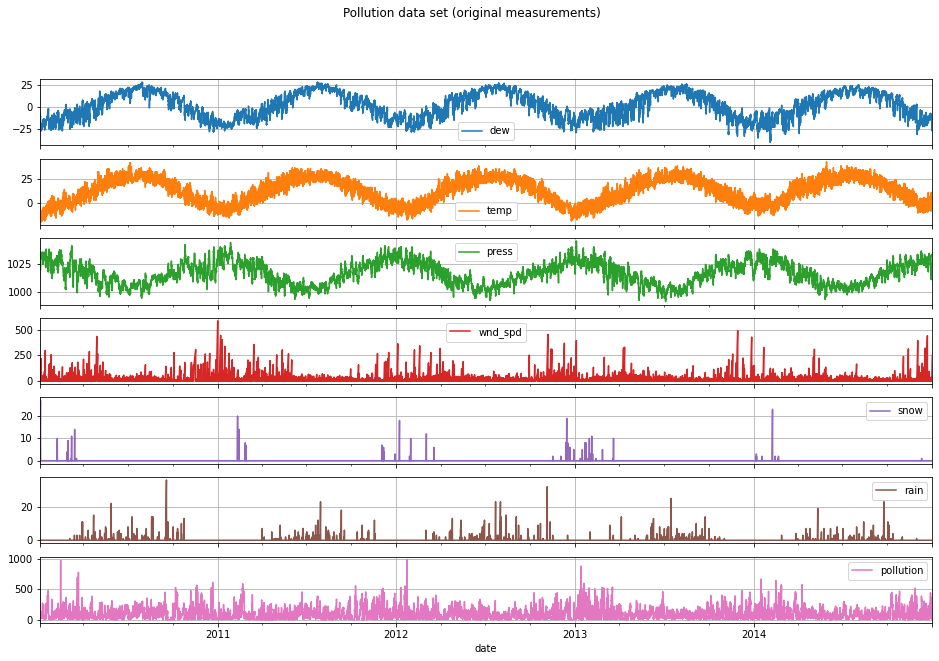

In [5]:
pollution_data = pd.read_csv(os.path.join(main_dir, "pollution.csv"), index_col = 0)
pollution_data.index = pd.to_datetime(pollution_data.index, format = "%Y-%m-%d %H:%M:%S")
pollution_data.plot(figsize = (16, 10), subplots = True, sharex = True, grid = True, title = "Pollution data set (original measurements)")

## Data transformation functions
The original data needs convenient pre-processing and transformation, in order to train a keras model with it.
Following functions convert the pandas dataframe into a collection of numpy arrays, with the shape required by keras recurrent models.

Preprocessing tasks are listed here below:
1. The whole data set is split into a training and testing set. The size of the testing set can be chosen by the user, but I can suggest a value of 0.25, in order not to penalize the amount of training data. Since we're dealing with time series, the train-test split can be easily done by simply helding out a fraction of the 'most recent' samples, due to the implicit dependecy of actual values of each feature, from the past ones. Under this assumption, there is no need of implementing any cross-validation (CV) methods during the training phase. 
As a direct consequence of the temporal dependency of the samples, one should never shuffle the samples, neither during model training phase.
2. The training set is used to fit a scaler object taken from sklearn, than both training and testing set are scaled accordingly. Note that it's important to reduce to a common scale both columns containing the input features and target column(s). 
3. Time-lagged dataframes are obtained by adding new columns iteratively, to the scaled dataframe, according to the specified number of lags (backward time steps) and number of forecasting timestamps (forward time steps). For example, if one wants to predict the target variables one step ahead, given the previous 10 values of the inputs, one should select 'lags = 10' and 'foreward_steps = 1'.
4. Dataframes values are reshaped to a three-dimensional numpy array. This operation is necessary, because keras' recurrent networks require input data be shaped like [batch_size, timestaps_per_batch, number_of_features]. In this case, the first dimension will be chosen to be equal to the total length of the observations contained in each dataframe (so, training will be performed on 1 batch of data) and there will be 1 timestamp per batch. One could adopt other strategies as well.

In [6]:
def series_to_supervised(data, lags = 1, forecasting_steps = 1, dropnan=True):
    """
    transforms a pandas dataframe or numpy matrix in a lagged dataframe given the time lags and the forecasting step
    Inputs:
        data : pd DataFrame or Numpy 2D array
        lags : int
            time lags (backward timestamps)
        forecasting_steps : int
                        timestamps in the future
        dropna : bool (default True)
                drop rows with any empty value
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(lags, 0, -1):
        cols.append(df.shift(i))
        names += [(df.columns[j]+'(t-%d)' %  i) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, forecasting_steps):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(df.columns[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(df.columns[j]+'(t+%d)' %  i) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop duplicate columns, if any
    agg = agg.loc[:,~agg.columns.duplicated()]
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def get_reframed_column_names(reframed_df, input_names, target_names, lags = 1, forecasting_steps = 1):
    """
    Get the names of the lagged columns (inputs) and the names of the columns to be forecasted (future values),
    given the lagged dataframe.
    Inputs:
        reframed_df : pd DataFrame 
            dataframe with lagged inputs and future values of the targets
        input_names : list of str
            list of all features used as inputs for prediction
        target_names : list of str
            list of all targets to be predicted
        lags : int
            time lags (backward timestamps)
        forecasting_steps : int
            timestamps in the future
    Outputs:
        X_column_names, Y_column_names : tuple of 2 lists
            Tuple containing the lists of all columns used as inputs (lagged values) and all columns to be forecasted (future values)

    """
    
    X_column_names = list()
    Y_column_names = list()
    
    for i in range (lags, 0, -1):
        if i ==0:
            s = "(t)"
        else:
            s = "(t-"+str(i)+")"
        for col_name in input_names:
            if col_name+s in reframed_df.columns.to_list():
                X_column_names.append(col_name+s)

    for j in range (0, forecasting_steps+1):
        if j == 0:
            s = "(t)"
        else:
            s = "(t+"+str(j)+")"
        for col_name in target_names: 
            if col_name+s in reframed_df.columns.to_list():
                Y_column_names.append(col_name+s)
                    
    return X_column_names, Y_column_names


def dataframe_to_keras_array(X, Y, lags, forecasting_steps, dropna = True, return_dataframe = False):
    """
    Wrapper of the previous functions, get the inputs and targets dataframes and returns a tuple of 3D numpy arrays that can be fed into a Keras model
    Inputs:
        X : pd DataFrame
            Inputs dataframe
        Y : pd DataFrame
            Targets dataframe
        lags : int
            Number of backward timestamps
        forecasting_steps : int
            Number of forward timestamps for the forecasts
        dropna : bol
            Drops rows with any NaN (default = True)
        return_dataframe : bol
            Choose to return 2 pd DataFrames instead of 2 numpy arrays. Default = False.
            May be useful for visualization or debugging purpose.
    """
    input_names = X.columns.to_list()
    target_names = Y.columns.to_list()
    
    reframed_df = series_to_supervised(data = pd.concat([X, Y], axis = 1),   
                                   lags = lags, 
                                   forecasting_steps = forecasting_steps, 
                                   dropnan = dropna)

    X_column_names, Y_column_names = get_reframed_column_names(reframed_df, input_names, target_names, lags = lags, forecasting_steps = forecasting_steps)

    if return_dataframe:
        X_keras_array = reframed_df[X_column_names]
        Y_keras_array = reframed_df[Y_column_names]
    else:
        timestamps_per_batch = 1
        batch_size = reframed_df.shape[0]
        X_keras_array = reframed_df[X_column_names].values.reshape(batch_size, timestamps_per_batch, len(X_column_names))
        Y_keras_array = reframed_df[Y_column_names].values.reshape(batch_size, timestamps_per_batch, len(Y_column_names))

    
    return X_keras_array, Y_keras_array

def data_preprocessing(df, input_names, target_names, test_fraction, scaler, lags, forecasting_steps):
    """
    General data preprocessing function. Given a data set in a tabular form, outputs a tuple of numpy arrays 
    to be used for training and scoring a LSTM network, and a sklearn fitted scaler, that was previously
    employed to scale the entries.
    
    Inputs:
        df : pd DataFrame
            Genneral tabular data set
        input_names : list of str
            Column names used as input variables
        target_names : list of str
            Column names defining the target variables
        test_fraction : float [0-1]
            The fraction of samples used for building the testing set
        scaler : sklearn scaler object
            Scaler used to pre-process numerical columns.
            It will be fitted on the training set, than both training and testing samples 
            will be transformed, according to the specified scaler strategy.
        lags : int
            Number of backward timestamps
        forecasting_steps : int
            Number of forward timestamps for the forecasts
            
    Outputs:
        X_train_reframed : 3D numpy array 
            Training data set with shape = [batch length, samples per batch, features]
            containing inoput variables. Numeric data are scaled.
        Y_train : 3D numpy array 
            Training data set with shape = [batch length, samples per batch, features]
            containing target variables. Numeric data are NOT scaled.
        X_test_reframed : 3D numpy array 
            Testing data set with shape = [batch length, samples per batch, features]
            containing inoput variables. Numeric data are scaled.
        Y_test : 3D numpy array 
            testing data set with shape = [batch length, samples per batch, features]
            containing target variables. Numeric data are NOT scaled.
        scaler : sklearn scaler object
            Fitted scaler. Useful to be called for next predictions.
    """
    
    # split training and testing set
    train_fraction = 1 - test_fraction
    
    X_train = df.iloc[0:round(train_fraction*df.shape[0])][input_names]
    X_test = df.iloc[round(train_fraction*df.shape[0])+1:df.shape[0]][input_names]

    Y_train = df.iloc[0:round(train_fraction*df.shape[0])][target_names]
    Y_test = df.iloc[round(train_fraction*df.shape[0])+1:df.shape[0]][target_names]   
    
    # scale the inputs
    scaler_X = scaler.fit(X_train) 
    scaler_Y = scaler.fit(Y_train)
    
    X_train_scaled = pd.DataFrame(data = scaler_X.transform(X_train)[:, 0:X_train.shape[1]], columns = X_train.columns, index = X_train.index)   
    X_test_scaled = pd.DataFrame(data = scaler_X.transform(X_test), columns = X_test.columns, index = X_test.index)
    
    Y_train_scaled = pd.DataFrame(data = scaler_Y.transform(Y_train), columns = Y_train.columns, index = Y_train.index)
    Y_test_scaled = pd.DataFrame(data = scaler_Y.transform(Y_test), columns = Y_test.columns, index = Y_test.index)
    
    #return dataframe_to_keras_array(X_train_scaled, Y_train, lags = lags, forecasting_steps = forecasting_steps, dropna = False)
    # transform the dataframes into 3D numpy arrays
    X_train_reframed, Y_train_reframed = dataframe_to_keras_array(X_train_scaled, Y_train_scaled, lags = lags, forecasting_steps = forecasting_steps)
    X_test_reframed, Y_test_reframed = dataframe_to_keras_array(X_test_scaled, Y_test_scaled, lags = lags , forecasting_steps = forecasting_steps)
        
    return X_train_reframed, Y_train_scaled, X_test_reframed, Y_test_scaled, scaler_Y

## Input features and target variables
For the purpose of this study, I assume that there are some numerical input features, and only 1 numerical target. The goal is to forecast the target (pollution indicator, intended as the amount of particulate matter) given the previous and actual value of the weather conditions, and only the previous value of the target itself.

More formally, I would like to obtain an estimator function F that can compute:

    pollution(t) = F(weather_conditions(t - 1), weather_conditions(t), pollution(t-1))
    
This is the reason why 'pollution' compares both in the 'input_names' and in the 'target_names' lists.

In the formula above, 'pollution' is the variable I want to forecast at the actual timestamp (t). Target values are known only in the past, while the features contained in 'weather conditions' can be considered as 'future covariates', because their values are known in the past, but also during the actual timestamp (t).

In [7]:
# decide which are the inputs and which are the outputs of the neural network
input_names = ['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain','pollution']
target_names = ['pollution']
backward_steps = 1
forward_steps = 1

## Call the data transformation utilites
All data preprocessing & transformation tasks have been joined in the 'data_preprocessing' function. I obtain a collection of 3D numpy arrays and the sklearn fitted scaler. The last object is necessary if one wants to use the coming mathematical model, to make forecasts given new data. Indeed, newcoming entries need to be scaled as well.

### Choice of data scaler
An appropriate scaler for data rescaling/normalizatio purpose can be chosen from sklearn.preprocessing module. Since we're dealing only with numerical features, a resonable choice is to start with a MinMaxScaler or better a StandardScaler. Both of them apply a linear transformation to all columns of the original dataframe. 

Other methodologies (taken from sklearn.preprocessing utilities) have been designed to reduce the importance of outliers or to change the variables distribution (see for example the PowerTransformer family).
For my implementation, I decided to use the QuantileTransformer, that scales the data according to the quantile range.

The simple function here below shows the new distributions obtained after the transformation.

In [8]:
def plot_histograms(df, stat = "count", title = "all features"):
    fig, axes = plt.subplots(figsize = (15, 15), nrows = df.shape[1])
    for ind, ax in enumerate(axes.flat):
        column_name = df.columns.to_list()[ind]
        sns.histplot(ax = axes[ind], data = df[column_name], label = column_name, stat = stat)
        axes[ind].legend(fontsize = 10)
        axes[ind].set_ylabel("")
        axes[ind].grid()
    plt.xlabel("")
    plt.suptitle(title, fontsize = 12)
    plt.tight_layout()

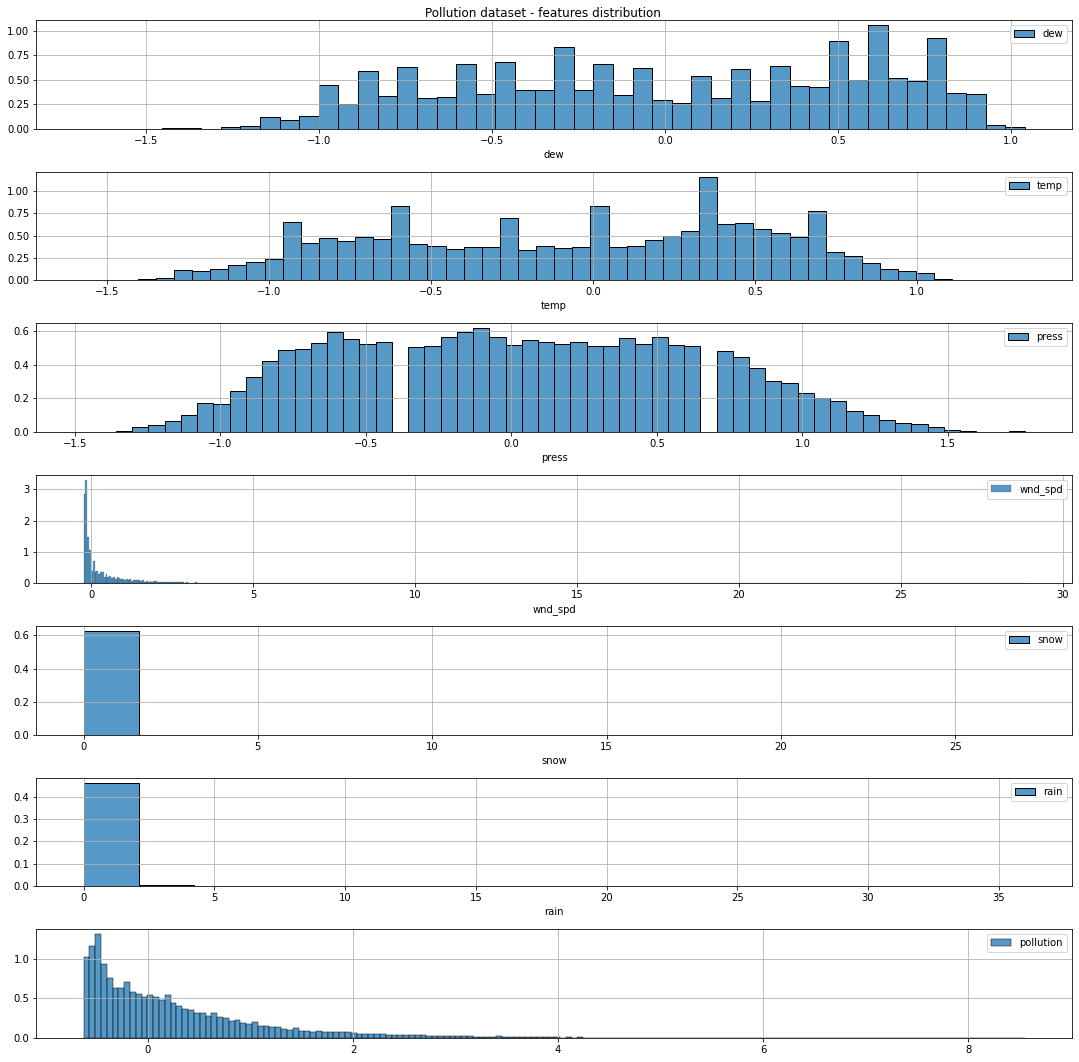

In [77]:
plot_histograms(pd.DataFrame(RobustScaler().fit_transform(pollution_data), columns = pollution_data.columns), 
                             stat = "density", title = "Pollution dataset - features distribution")

#### Observation on the scaled data distributions
Both input features and target variable are scaled accordingly to che chosen procedure. Note that the extrema (min and max samples) of all variables have the same magnitude, but the underlaying distributions are preserved. Low/high samples are preserved too, meaning that they are not mapped to the 'bulk' of the samples as could happen by applying a QuantileTransformer.

In [10]:
X_train_reframed, Y_train, X_test_reframed, Y_test, scaler_Y = data_preprocessing(df = pollution_data, 
                                                                                input_names = input_names, 
                                                                                target_names = target_names, 
                                                                                test_fraction = 0.25, 
                                                                                scaler = RobustScaler(), 
                                                                                lags = 1, 
                                                                                  forecasting_steps = 1)

In [11]:
Y_train.shape

(32850, 1)

In [12]:
X_test_reframed.shape

(10948, 1, 7)

In [13]:
Y_test.shape

(10949, 1)

## Basic sequential model
The easiest way to think about a keras' model is via the Sequential class. The model is practically a stack of sequential layers, each one transforming data with an input-output logic.

In this study, I first decided to try out a 2-layer LSTM network. Note that since I did not use any pre-processing or input layers, I had to specify the input shape explicitly in the first LSTM layer. Since the second is another recurrent layer, one has to set 'return sequences = True' property in the first layer. This argument tells whether to return the output at each time steps instead of the final time step.
The last Dense layer works as an output layer and has the same shape of the target numpy array.

In [14]:
# design network
model = Sequential()
model.add(LSTM(units = 20, 
               input_shape=(X_train_reframed.shape[1], X_train_reframed.shape[2]), # (num_timestamps, num_features), batch size unknown in advance
              return_sequences=True, dropout=0.1))

# the first LSTM layer has to return a sequence (not a scalar value) as output. That's why return sequence = True
model.add(LSTM(units = 20, return_sequences=False, dropout=0.1)) # here the output is a 2D array (batch_size, features) and only last sample
model.add(Dense(Y_train.shape[1]))

### Compiling the model
I specified some error metrics (that are computed both on the training and validation data) and a modelling error loss score. Actually it is possible to set only a scalar error score. Reasonable choices can be the mean squared error, mean absolute error, mean percentage error etc, for regression and forecasting purpose.

I chose the MSE as model error score, since it's going to penalize high deviations of the predicted values from real data.

In [78]:
# Compiling the ANN
metrics=['mean_squared_error', 'mean_absolute_error', RSquare()]
# select the modelling error metric 
modelling_error_metric = 'mean_absolute_error'
model.compile(optimizer = 'Adam', loss = modelling_error_metric, metrics = metrics)
#model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 20)             2240      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 5,541
Trainable params: 5,541
Non-trainable params: 0
_________________________________________________________________


### Fitting the model
One of the most important details for practitioners, is to set a stopping criteria for the weights optimization procedure. In the actual case, I selected 'Adam' algorithm to fit the model (i.e. look for the best set of weights that reproduce the wanted results). The keras-like way of working implies to set a max number of epochs (the algorithm stops updating the weight when this number is reached), but adding an eary stopping callback significantly reduces the computational effort. 
Adding early stopping practically means adding another stopping criterion: with the below code, the weights set research will stop if the validation loss does not improve more than 'min_delta', over the numeber of epochs specified by 'patience'. 
Other interesting callbacks are listed in the keras doc.

Another important point here: one has to enter the batch size (the number of samples on which weights update is computed), the ratio of validation entries and the steps per epoch, out of the training loop. From an hyperparameter tuning point of view, these values are still setting parameters.

In [16]:
# add an early stopping criteria, to stop training if improvement in the 
# validation score is not growing. This should improve time coinsumption.
early_stopping = EarlyStopping(monitor='val_loss', verbose = 0, patience = 5, min_delta = 1e-5, restore_best_weights = True)

# fit network
start_time = time.time()
history = model.fit(X_train_reframed, 
                    Y_train, 
                    epochs=300, 
                    batch_size=32, 
                    validation_split = 0.20, 
                    steps_per_epoch = None,
                    verbose=1, # 0 == quiet
                    shuffle=False, 
                    callbacks=[early_stopping, TerminateOnNaN()],
                    use_multiprocessing = True)

elapsed_time = time.time() - start_time
print("\nThe first network took {} s to complete training.".format(round(elapsed_time)))

Epoch 1/300
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
818/822 [============================>.] - ETA: 0s - lo

### Plotting the training history
It is useful to plot the trend of both training and validation scores per epochs, to get an insight of the training behavior. Both scores are supposed to decrease as long as the training advances, but at a certain epoch the decay should be more or less asymptotic.

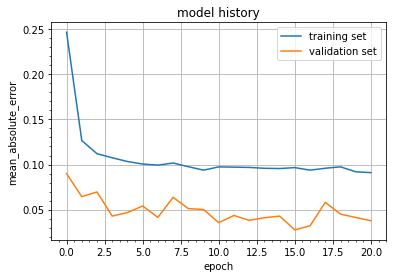

In [17]:
# plot history
plt.title("model history")
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='validation set')
plt.xlabel("epoch")
plt.ylabel(modelling_error_metric)
plt.grid() 
plt.minorticks_on()
plt.legend()

### Model evaluation on the testing set
Finally, the sample model can be scored using the testing set. This could provide a point estimate of the model generalization capability.

In [18]:
model_scores = model.evaluate(X_test_reframed, Y_test.iloc[backward_steps:], batch_size = None, verbose = 0, use_multiprocessing = True)
model_scores

[0.12296322733163834,
 0.05380362272262573,
 0.12296322733163834,
 0.9299625158309937]

In [19]:
model.metrics_names

['loss', 'mean_squared_error', 'mean_absolute_error', 'r_square']

### Calculate forecasts
Predictions are expressed in the same scale of the labelled data used for model scoring.

In [20]:
Y_predicted_reframed = model.predict(X_test_reframed,  batch_size = 32, verbose = 0, use_multiprocessing = True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### Reshape the output 
Forecasts are returned as a 3D array (like the inputs). To make the data manipulation easier, it's convenient to transform the array back to a 2D array. We practically get rid of the 2nd dimension.

In [21]:
Y_predicted_scaled = Y_predicted_reframed.reshape(Y_predicted_reframed.shape[0], Y_predicted_reframed.shape[1])

### Reverse scale the outputs
The final step to get the forecasts in their original magnitude consists in calling the previously fitted scaler_Y object and perform reverse scaling.

Note that the scaler was fit with training data that may be far from testing data. The overall forecasting error should be computed providing the test data in their original scale and the reverse-scaled forecasts, since this kind of formulation takes into account the bias introduced by the scaler. This contribution to the forecasting error is hard to avoid, because the scaler has been correctly fit on training data only, and has no knowledge about testing data.

In [22]:
Y_predicted = scaler_Y.inverse_transform(Y_predicted_scaled)

### Compare test data and forecasts
The function below produces a line plot of test data and forecasts.

In [23]:
def plot_results(Y_test, Y_predicted, title = "Test data and predictions", index = None):
    if index is None:
        index = range(0, Y_test.shape[0])
    df_index = pd.DataFrame(data = index, index = range(0, Y_test.shape[0]))
    df_index.columns = ["user_index"]  

    shift = Y_test.shape[0] - Y_predicted.shape[0]

    fig, axes = plt.subplots(figsize = (16, 10), sharex = True, nrows = Y_test.shape[1], squeeze = False)
    
    for target, ax in enumerate(axes.flat):
        ax.step(df_index.values, Y_test[:,target], where = "post", label = "testing set", color = "blue")
        ax.step(df_index.loc[shift:, "user_index"].values, Y_predicted[:,target], where = "post", label = "predictions", color = "red")
    
    plt.suptitle(title)
    plt.legend()

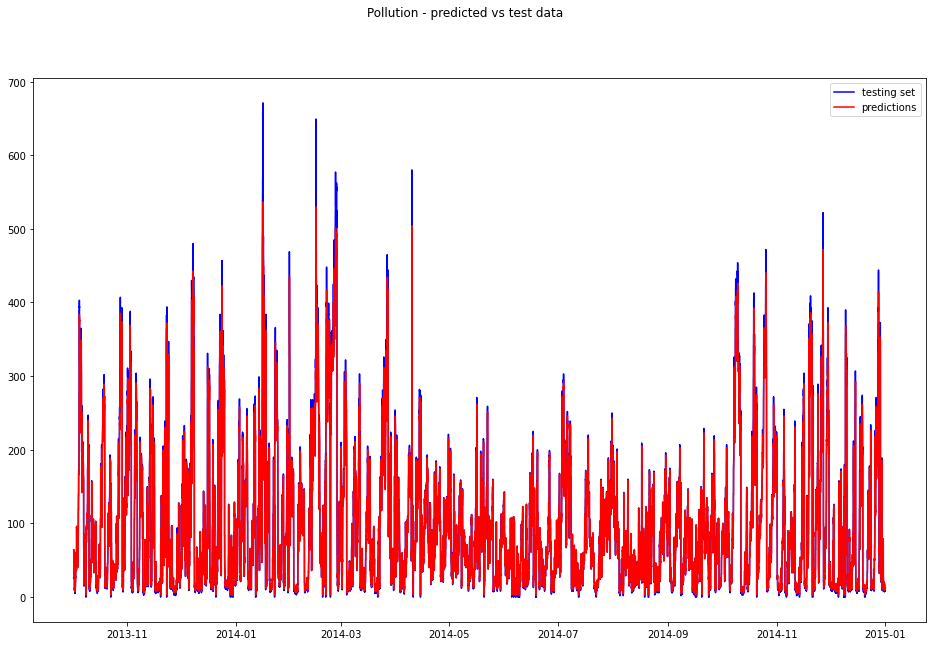

In [24]:
    
plot_results(scaler_Y.inverse_transform(Y_test.values), Y_predicted, index = Y_test.index, title = "Pollution - predicted vs test data")

In [25]:
Y_predicted.shape, Y_test.shape

((10948, 1), (10949, 1))

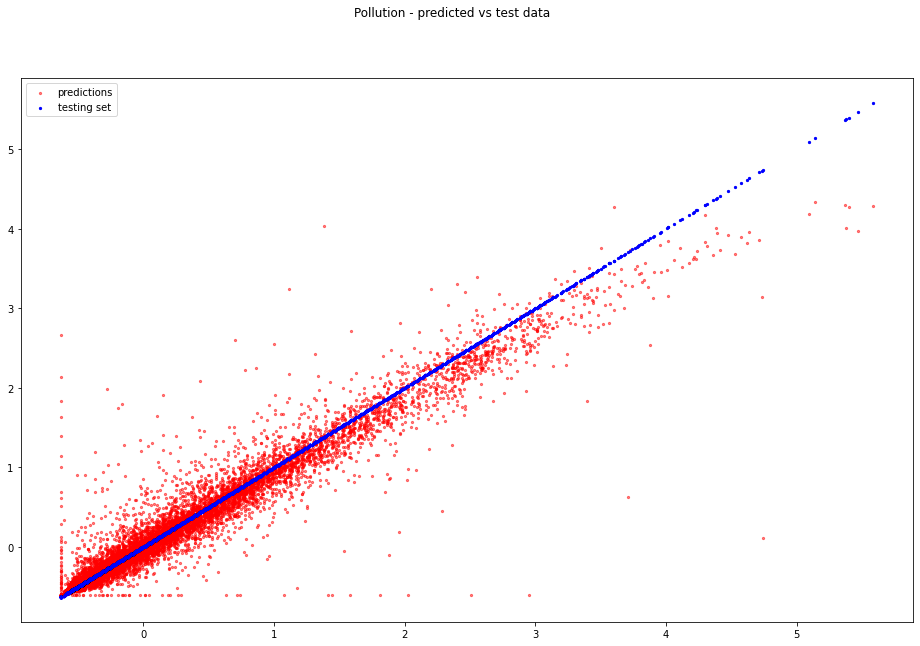

In [26]:
def qq_plot(Y_test, Y_predicted, title = "Test data and predictions", index = None):
    if index is None:
        index = range(0, Y_test.shape[0])
    df_index = pd.DataFrame(data = index, index = range(0, Y_test.shape[0]))
    df_index.columns = ["user_index"]  

    shift = Y_test.shape[0] - Y_predicted.shape[0]

    fig, axes = plt.subplots(figsize = (16, 10), sharex = True, nrows = Y_test.shape[1], squeeze = False)
    
    for target, ax in enumerate(axes.flat):
        ax.scatter(Y_test[shift:,target], Y_predicted[:,target], label = "predictions", color = "red", s = 5, alpha = 0.5)
        ax.scatter(Y_test[:,target], Y_test[:,target], label = "testing set", color = "blue", s = 5)

    plt.suptitle(title)
    plt.legend()

qq_plot(Y_test.values, Y_predicted_scaled, index = Y_test.index, title = "Pollution - predicted vs test data")

### Comments on the numerical results
Pollution forecasts are overall acceptable, with an R^2 score bigger than 0.90. 
Residuals are higher for higher values of pollution, meaning that the model is more imprecise in predicting the spikes. The root cause here lays in the target data distribution (the majority of the samples represent low values of pollution) and in the train/test split. It is more likely that testing set contains more samples with higher values of pollution, which could not be experienced during training.

## Network hyperparameters optimization
Since the sample network provided satisfactory preliminary results, we can expect that fine tuning an LSTM network will at least improve the model generalization capability.
In the following section of the notebook, I'm going to test the hyperparameters (HP) tuning procedure, mainly using keras_tuner library.
Before calling the 'search' function (which will actually explorie and evaluate the HP space), I need to:
1. Instantiate and populate a HyperParameters class: this class contains the HPs space. At each iteration, a new set of HPs is chosen and used to build a new model. Note that some HPs are defined outside the HyperModel class (number of LSTM layers, Adam's learning rate, batch size), while the remaining HPs depends from the number of LSTM layers.
2. Create a custom HyperModel object: I sub-classed keras' HyperModel to override the build() and fit () methods, using custom HPs. This is particulary useful to define condition-based HPs (like the ones in the 'for' loop) and introducing HPs related to the training algorithm.

In [27]:
hp = HyperParameters()
hp.Int("n_layers", min_value= 1 , max_value = 3) 
hp.Choice("learning_rate", [1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
hp.Int("batch_size", min_value = 8, max_value = 512, step = 8)

8

### Subclassing the HyperModel class
This is an elegant way to group both model architechture and fitting hyperparameters in a single entity.
I overrode the 'build' and 'fit' methods, because the first one builds the hypermodel, given the hyperparamenters objects and populates the LSTM layers in a customized way, while the second one allows to set the change the batch size used for fitting the hypermodel, consequently.

In [50]:
class custom_HyperModel(HyperModel):
    def build(self, hp):
        
        model = tf.keras.Sequential()
        # add the hidden layers in a variable quantity. This requires a loop.
        for i in range(hp.get('n_layers')):
            model.add(
                tf.keras.layers.LSTM(
                    input_shape = (X_train_reframed.shape[1], X_train_reframed.shape[2]),
                    return_sequences = True,
                    name = f"LSTM_layer_{i+1}",

                    units = hp.Int(f"LSTM_layer_{i+1}_units", min_value = X_train_reframed.shape[-1], 
                                   max_value = (X_train_reframed.shape[-1]**2)),

                    activation = hp.Choice(f"LSTM_layer_{i+1}_activation", ['relu','sigmoid','tanh', 'exponential']),

                    recurrent_activation = hp.Choice(f"LSTM_layer_{i+1}_recurrent_activation", ['relu','sigmoid', 'tanh', 'exponential']),

                    use_bias = hp.Boolean(f"LSTM_layer_{i+1}_use_bias"),

                    unit_forget_bias = hp.Boolean(f"LSTM_layer_{i+1}_unit_forgot_bias"),

                    dropout=hp.Float(name = f"LSTM_layer_{i+1}_dropout_rate", min_value = 0, max_value = 0.5, step = 0.1),

                    recurrent_dropout = hp.Float(name = f"LSTM_layer_{i+1}_recurrent_dropout_rate", min_value = 0, max_value = 0.5, step = 0.1)

                                      )
                        )

        # add the output layer
        model.add(tf.keras.layers.Dense(name = 'output_layer', 
                                        units = Y_train.shape[1],
                                        activation = 'linear')
                  )

        # compiling the ANN
        metrics=['mean_squared_error',  
                 'mean_absolute_error',
                RSquare().build(input_shape = (Y_train.shape[1],))] # added this modification (called build method) to avoid error on input shape

        # select the modelling error metric 
        loss_function = 'mean_squared_error'

        # compile the model
        model.compile(optimizer = optimizers.Adam(learning_rate = hp.get('learning_rate')), loss = loss_function, metrics = metrics)

        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(*args, batch_size = hp.get('batch_size'), **kwargs)
    

### Instantiate a Tuner
I used Hyperband algorithm for hyperparameters tuning task, but BayesianSearch is a clever choice too. In any case, these choices reduce the computational effort by exploring the hyperparameters space in a more intelligent way than the basic GridSearch and RandomSearch algorithms.

In [51]:
# instantiate a Tuner 
tuner = Hyperband(custom_HyperModel(),
                    hyperparameters = hp,
                    objective = 'val_loss', 
                    project_name ="time_hyperband_LSTM_tuning",
                    max_epochs = 300, #maximum number of epochs to train one model
                    hyperband_iterations = 1,  #the number of times to iterate over the full Hyperband algorithm
                    factor = 6, # changed from 3 to 10
                    directory = main_dir,
                    distribution_strategy = tf.distribute.MirroredStrategy(["/cpu:0","/cpu:1", "/cpu:2", "/cpu:3"]),
                    tuner_id = "Hyperband",
                    overwrite = True, 
                    )

#### Estimate Hyperband's workload
The total number of iteration and computational time cannot be calculated in a precise way, but we can do something to get a hint of how long it will take to get the final result. 

According to keras' documentation, Hyperband algorithm can be run for more iterations (but I will limit them to 1, in order to save time) and the user can provide a 'max_epochs' and 'factor' parameters. 'max_epochs' is the max number of epochs allowed to fit each hypermodel and they recommend to use a value slightly higher than the one used to fit the largest model. Since the fitting procedure has a stochastic nature, convergency speed may depend on the random set of weights used for initialization. Moreover, the presence of early stopping callback is supposed to dramatically reduce the effective number of training epochs. For these reasons, it's hard to say how long it will take to train a hypermodel instance.
'factor' can be seen a load reduction parameter, comparing in the logarithmic formula here below, that is used to estimate the total number of epochs the algorithm will be run.

A rough estimate of the overall computational time can be obtained by multiplying the expected number of total epochs by the sec/epoch ratio we experienced fitting the previous model.

In [79]:
def estimate_hyperband_load(max_epochs, factor, hyperband_iterations = 1, sec_per_epoch = None):
    total_epochs = round(hyperband_iterations * max_epochs * (math.log(max_epochs, factor) ** 2))
    estimate_runtime = "Unknown, provide sec_per_epoch to compute."
    if not sec_per_epoch == None:
        estimate_runtime = str(timedelta(seconds = round(sec_per_epoch * total_epochs)))
    return total_epochs, estimate_runtime

estimate_hyperband_load(300, 6, sec_per_epoch = 60/21)

(3040, '2:24:46')

Given the actual inputs, we expect Hyperband will run approximately 2 hours and a half. So make sure you have enough time before running the research!

One could also reduce the hyperparameters space and try to reduce the number of epochs, until an acceptable overall computational time is achieved.

### Running the hyperparameters search 
The HPs search will be run using only the training data set. No shuffling should be specified due to the dependency of actual samples from the historical samples. A validation fraction of 0.20 is a popular choice. The validation sub-set is automatically selected in each data batch and used to compute the error metric 'val_loss'. 

Callbacks are passed to the hypermodel class and are useful to stop training a hypermodel if something goes wrong (validation loss is nan) or itroducing early stopping criterion.

In [53]:
# perform hyperparameters tuning
tuner.search(X_train_reframed, 
             Y_train, 
             steps_per_epoch = None, 
             shuffle = False, 
             validation_split = 0.20, 
             verbose = 1, #
             callbacks = [EarlyStopping(monitor='val_loss', verbose = 0, patience = 3, min_delta = 1e-5, restore_best_weights = True), 
                          History(), TerminateOnNaN()], 
             use_multiprocessing = True, 
            )

Trial 420 Complete [00h 03m 09s]
val_loss: 0.008690567687153816

Best val_loss So Far: 0.015129927545785904
Total elapsed time: 03h 39m 52s


### Get the best hyperparamaeters set
A convenient way to get the results of the HPs research is by accessing the hyperparameters set that achieved the lowest error score and use them to instanciate a new hypermodel.

In [81]:
best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hps)

In [60]:
best_hps.values

{'n_layers': 2,
 'learning_rate': 0.001,
 'batch_size': 224,
 'LSTM_layer_1_units': 20,
 'LSTM_layer_1_activation': 'sigmoid',
 'LSTM_layer_1_recurrent_activation': 'tanh',
 'LSTM_layer_1_use_bias': True,
 'LSTM_layer_1_unit_forgot_bias': False,
 'LSTM_layer_1_dropout_rate': 0.1,
 'LSTM_layer_1_recurrent_dropout_rate': 0.2,
 'LSTM_layer_2_units': 33,
 'LSTM_layer_2_activation': 'exponential',
 'LSTM_layer_2_recurrent_activation': 'exponential',
 'LSTM_layer_2_use_bias': True,
 'LSTM_layer_2_unit_forgot_bias': False,
 'LSTM_layer_2_dropout_rate': 0.0,
 'LSTM_layer_2_recurrent_dropout_rate': 0.2,
 'LSTM_layer_3_units': 14,
 'LSTM_layer_3_activation': 'sigmoid',
 'LSTM_layer_3_recurrent_activation': 'relu',
 'LSTM_layer_3_use_bias': False,
 'LSTM_layer_3_unit_forgot_bias': False,
 'LSTM_layer_3_dropout_rate': 0.5,
 'LSTM_layer_3_recurrent_dropout_rate': 0.4,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 3,
 'tuner/round': 0}

## Re-training the best model
Once the model architecture has been chosen, we can train the model on the same training set (since we don't have other held out data sets), without validation splits. 

An important point is the specification of 'loss' and not 'val_loss' in the early stopping callback (there is no validation score).

In [82]:
best_model.fit(X_train_reframed, Y_train[1:], 
               epochs = 300,     
               shuffle = False,
               steps_per_epoch = None,
               validation_split = 0,
               batch_size = best_hps["batch_size"],
               callbacks = [EarlyStopping(monitor='loss', verbose = 0, patience = 3, min_delta = 1e-5, restore_best_weights = True), 
                              History(), TerminateOnNaN()],
               verbose = 1,
               use_multiprocessing = True
              )

Epoch 1/300
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
147/147 [==============================] - 5s 4ms/step - loss: 0.2631 - mean_squared_error: 0.2631 - mean_absolute_error: 0.3330
Epoch 2/300
147/147 [==============================] - 1s 4ms/step - loss: 0.1274 - mean_squared_error: 0.1274 - mean_absolute_error: 0.1991
Epoch 3/300
147/147 [==============================] - 1s 4ms/step - loss: 0.1196 - mean_squared_error: 0.1196 - mean_absolute_error: 0.1891
Epoch 4/300
147/147 [==============================] - 1s 4ms/step - loss: 0.1109 - mean_squared_error: 0.1109 - mean_absolute_error: 0.1844
Epoch 5/300
147/147 [==============================] - 1s 4ms/step - loss: 0.1119 - mean_squared_error: 0.1119 - mean_absolut

### Making forecasts
Now we can use the fitted model to make predictions on the held-out set. Reshaping and reverse scaling follows the same procedure used during the experiment with the sample LSTM network.

In [68]:
Y_predicted_reframed = best_model.predict(X_test_reframed)

Y_predicted = Y_predicted_reframed.reshape(Y_predicted_reframed.shape[0], Y_predicted_reframed.shape[1])

343/343 [==============================] - 0s 1ms/step


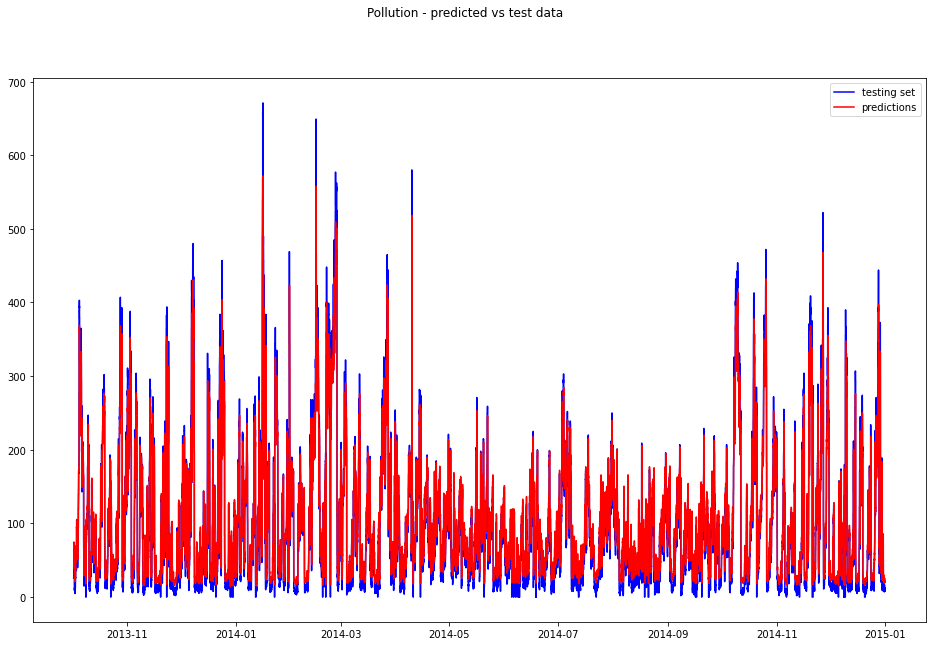

In [69]:
plot_results(scaler_Y.inverse_transform(Y_test.values), scaler_Y.inverse_transform(Y_predicted),
             index = Y_test.index, title = "Pollution - predicted vs test data")

In [70]:
test_scores = best_model.evaluate(X_test_reframed, Y_test[backward_steps:], batch_size=best_hps["batch_size"], 
                                    use_multiprocessing=True,
                                 )
test_scores

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/49 [==============================] - 1s 2ms/step - loss: 0.0632 - mean_squared_error: 0.0632 - mean_absolute_error: 0.1619


[0.06317180395126343, 0.06317180395126343, 0.16193409264087677]

## Comments
The overall performance is comparable with the one obtained with the sample LSTM network. There is still higher inaccuracy in predicting the pollution spikes and very low values. This could been inherited by the choice of train/test split and data scalers.
Dropout rate could also be further improved by setting a lower values.

In [71]:
from sklearn.metrics import *

In [85]:
r2_score(Y_test[backward_steps:], Y_predicted)

0.9177677076708102

### Model import/export

In [86]:
best_model.save("best_model_with_hyperband")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [87]:
tf.keras.models.load_model("best_model_with_hyperband")

## References
### Time series forecasting theory
Forecasting: Principles and Practice, Rob J Hyndman and George Athanasopoulos, https://otexts.com/fpp2/

### Data reshaping to 3D numpy array
https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

### Data rescaling
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

### Keras and keras-tuner
https://keras.io/getting_started/
https://keras.io/keras_tuner/

### Batch size training for recurrent networks
https://stats.stackexchange.com/questions/526670/how-to-choose-a-batch-size-and-the-number-of-epochs-while-training-a-nn
https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/

### Tensorflow 
https://www.tensorflow.org/

### Multivariate time series forecasting approaches
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/